In [1]:
import time
import numpy as np
import matplotlib.pylab as plt
from ridgeplot import ridgeplot
import pandas as pd

import torch
import torch
from torch.utils.data import Dataset, DataLoader

from gluformer.attention import *
from gluformer.encoder import *
from gluformer.decoder import *
from gluformer.embed import *
from gluformer.model import *
from utils.train import *


In [2]:
def generate_mean(off, modes, lens, betas):
    mean = np.zeros((288))
    mean[:lens[0]] = off + np.sin((2 * np.pi / 12) * np.arange(0, lens[0])) * betas[0, 0] + np.sin((2 * np.pi / 36) * np.arange(0, lens[0])) * betas[0, 1]
    ch = np.random.choice(list(range(len(modes))), 1)[0]
    mean[lens[0]:lens[1]] = modes[ch] + off + np.sin((2 * np.pi / 12) * np.arange(lens[0], lens[1])) * betas[1, 0] + np.sin((2 * np.pi / 36) * np.arange(lens[0], lens[1])) * betas[1, 1]
    mean[lens[1]:lens[2]] = off + np.sin((2 * np.pi / 12) * np.arange(lens[1], lens[2])) * betas[2, 0] + np.sin((2 * np.pi / 36) * np.arange(lens[1], lens[2])) * betas[2, 1]
    
    return mean

cov1 = np.zeros((288, 288))
row = np.array([1] + [1 / abs(i) for i in range(1, 288)])
for i in range(288):
    cov1[i, :(i+1)] = np.flip(row[:(i+1)])
    cov1[i, (i+1):] = row[1:(288-i)]
np.fill_diagonal(cov1, 2)

train_samples = 2000
val_samples, test_samples = 100, 100

modes1 = [-40, 40]
off1 = 0
lens1 = [100, 200, 288]
# betas1 = np.random.uniform(1, 3, (3, 2))
betas1 = torch.load('betas.pth')
# torch.save(betas1, './betas.pth')

# modes2 = [5, -5, 13]
# off2 = 50
# lens2 = [90, 180, 288]
# betas2 = np.random.uniform(1, 3, (3, 2))

train_data = []
val_data = []
test_data = []
for i in range(train_samples):
    if i < val_samples:
        val_data.append([0,
                        np.random.multivariate_normal(generate_mean(off1, modes1, lens1, betas1), cov1).reshape((-1, 1)), 
                        np.arange(288, dtype=np.float32).reshape((-1, 1))])
        # val_data.append([1,
        #                 np.random.multivariate_normal(generate_mean(off2, modes2, lens2, betas2), cov1).reshape((-1, 1)),
        #                 np.arange(288, dtype=np.float32).reshape((-1, 1))])
        test_data.append([0,
                        np.random.multivariate_normal(generate_mean(off1, modes1, lens1, betas1), cov1).reshape((-1, 1)), 
                        np.arange(288, dtype=np.float32).reshape((-1, 1))])
        # test_data.append([1,
        #                 np.random.multivariate_normal(generate_mean(off2, modes2, lens2, betas2), cov1).reshape((-1, 1)),
        #                 np.arange(288, dtype=np.float32).reshape((-1, 1))])

    train_data.append([0,
                    np.random.multivariate_normal(generate_mean(off1, modes1, lens1, betas1), cov1).reshape((-1, 1)), 
                    np.arange(288, dtype=np.float32).reshape((-1, 1))])
    # train_data.append([1,
                    # np.random.multivariate_normal(generate_mean(off2, modes2, lens2, betas2), cov1).reshape((-1, 1)),
                    # np.arange(288, dtype=np.float32).reshape((-1, 1))])

In [3]:
maxx = np.max([train_data[i][1].max() for i in range(len(train_data))])
minn = np.min([train_data[i][1].min() for i in range(len(train_data))])

train_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / 287] for data in train_data]

val_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / 287] for data in val_data]


test_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / 287] for data in test_data]

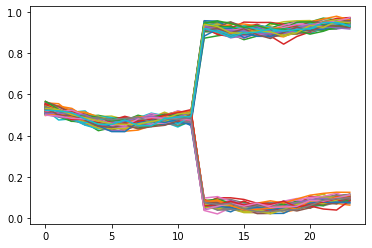

In [4]:
plot_test = np.vstack([data[1].reshape((1, -1)) for data in test_data])
out = plt.plot(plot_test[:, 88:112].transpose())
plt.show()

In [5]:
pd.DataFrame(plot_test).to_csv('./saved_output/exp/full_true_sample.csv', index=False)

In [5]:
class Data(Dataset):
  def __init__(self, data, flag='train', size=None):
    # size [seq_len, label_len, pred_len]
    # info
    self.seq_len = size[0]
    self.label_len = size[1]
    self.pred_len = size[2]
    
    # init
    self.data = data
    len_segs = np.array([len(subj_seg[1]) for subj_seg in self.data])
    len_segs = len_segs - self.seq_len - self.pred_len + 1
    self.len_segs = np.insert(np.cumsum(len_segs), 0, 0)
  
  def __getitem__(self, index):

    idx_seg = np.argmax(self.len_segs > index) - 1
    seg = self.data[idx_seg]

    s_begin = index - self.len_segs[idx_seg]
    s_end = s_begin + self.seq_len
    r_begin = s_end - self.label_len
    r_end = r_begin + self.label_len + self.pred_len

    subj_id = seg[0]
    seq_x = seg[1][s_begin:s_end]
    seq_y = seg[1][r_begin:r_end]
    seq_x_mark = seg[2][s_begin:s_end]
    seq_y_mark = seg[2][r_begin:r_end]

    return subj_id, seq_x, seq_y, seq_x_mark, seq_y_mark
  
  def __len__(self):
    return self.len_segs[-1]

In [6]:
len_seq, len_label, len_pred = 60, 12 ,12

train_data = Data(train_data, size=[len_seq, len_label, len_pred])
val_data = Data(val_data, size=[len_seq, len_label, len_pred])
test_data = Data(test_data, size=[len_seq, len_label, len_pred])

In [7]:
num_samples = 5
batch_size = 256
collate_fn_custom = modify_collate(num_samples)

train_data_loader = DataLoader(train_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

val_data_loader = DataLoader(val_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

test_data_loader = DataLoader(test_data, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                drop_last=False,
                                collate_fn = collate_fn_custom)


In [8]:
device = torch.device('cuda:0')
model = Gluformer(d_model=256, 
                    n_heads=4, 
                    d_fcn=1024, 
                    r_drop=0.4, 
                    activ="relu", 
                    num_enc_layers=2, 
                    num_dec_layers=1,
                    distil=True,
                    len_seq=len_seq, 
                    len_pred=len_pred,
                    num_features=1)
model.train()
model = model.to(device)

In [9]:
epochs = 10
criterion =  ExpLikeliLoss(num_samples)
model_optim = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0, 0.9))

# define params for training
TRAIN_STEPS = len(train_data_loader)
early_stop = EarlyStop(5, 0)

for epoch in range(epochs):
    iter_count = 0
    train_loss = []
    
    epoch_time = time.time()
    curr_time = time.time()
    
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        # zero-out grad
        model_optim.zero_grad()
        pred, true, logvar = process_batch(subj_id=subj_id, 
                                batch_x=batch_x, 
                                batch_y=batch_y, 
                                batch_x_mark=batch_x_mark, 
                                batch_y_mark=batch_y_mark, 
                                len_pred=len_pred, 
                                len_label=len_label, 
                                model=model, 
                                device=device)
        loss = 0
        loss = criterion(pred, true, logvar)

        train_loss.append(float(loss.item()))
        # print every 100
        if (i+1) % 100==0:
            print("\t iters: {0} / {3}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item(), TRAIN_STEPS))
            logvar = logvar.reshape(-1, num_samples)
            print("\t variance: ",np.exp(logvar.detach().cpu().numpy()[0, :]))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((epochs - epoch) * TRAIN_STEPS - i)
            print('\t speed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            curr_time = time.time()
        
        loss.backward()
        model_optim.step()
    # compute average train loss
    train_loss = np.average(train_loss)

    # compute validation / test loss + metric
    with torch.no_grad():
        val_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id, 
                                    batch_x=batch_x, 
                                    batch_y=batch_y, 
                                    batch_x_mark=batch_x_mark, 
                                    batch_y_mark=batch_y_mark, 
                                    len_pred=len_pred, 
                                    len_label=len_label, 
                                    model=model, 
                                    device=device)
            loss = criterion(pred, true, logvar)
            val_loss.append(float(loss.item()))
        val_loss = np.average(val_loss)

        test_metric = {3: [], 6: [], 9: [], 12:[]}; test_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id, 
                                    batch_x=batch_x, 
                                    batch_y=batch_y, 
                                    batch_x_mark=batch_x_mark, 
                                    batch_y_mark=batch_y_mark, 
                                    len_pred=len_pred, 
                                    len_label=len_label, 
                                    model=model, 
                                    device=device)
            loss = criterion(pred, true, logvar)
            test_loss.append(float(loss.item()))

            # compute metrix: APE
            pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
            # transform back to data space
            # pred = (pred + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
            # true = (true + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
            # arrange in proper shape
            pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
            pred = np.mean(pred, axis=2)
            true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))[:, :, 0]
            # compute APE: 15 mins (3 points), 30 mins (6 points), 45 mins (9 points), full (12 points)
            for i in [3,6,9,12]:
                test_metric[i].append(np.mean(np.abs(true[:, :i] - pred[:, :i]) / true[:, :i]))
        test_loss = np.average(test_loss)
        for i in [3,6,9,12]:
                test_metric[i] = np.median(test_metric[i])
    
    # check early stopping
    early_stop(val_loss, model, 'model_best_exp.pth')
    if early_stop.stop:
        print("Early stopping...")
        break

    # update lr
    # adjust_learning_rate(model_optim, epoch, lr)
    
    print("Epoch: {0} Time: {1} Steps: {2}".format(epoch+1, time.time() - epoch_time, TRAIN_STEPS))
    print("Train Loss: {0:.7f} | Val Loss: {1:.7f} | Test Loss: {2:.7f}".format(train_loss, val_loss, test_loss))
    print("Test Loss (15 mins): {0:.7f} | (30 mins): {1:.7f} | (45 mins): {2:.7f} | (60 mins): {3:.7f}".format(
        test_metric[3], test_metric[6], test_metric[9], test_metric[12]))

	 iters: 100 / 1695, epoch: 1 | loss: -19.2327576
	 variance:  [0.00480435 0.00984191 0.04517918 0.1835314  0.42579395]
	 speed: 0.4989s/iter; left time: 8406.8590s
	 iters: 200 / 1695, epoch: 1 | loss: -20.6559906
	 variance:  [0.00108809 0.00416443 0.8401293  0.00814408 0.01599343]
	 speed: 0.4969s/iter; left time: 8323.0873s
	 iters: 300 / 1695, epoch: 1 | loss: -27.7195129
	 variance:  [0.01718808 0.00120108 0.00752435 0.00686611 0.00090645]
	 speed: 0.4968s/iter; left time: 8272.2797s
	 iters: 400 / 1695, epoch: 1 | loss: -22.8466148
	 variance:  [0.00529286 0.00856947 0.09935493 0.07061978 0.00291337]
	 speed: 0.4969s/iter; left time: 8223.5232s
	 iters: 500 / 1695, epoch: 1 | loss: -29.4214516
	 variance:  [0.00603063 0.0198487  0.00426929 0.00102921 0.02020592]
	 speed: 0.4970s/iter; left time: 8176.2045s
	 iters: 600 / 1695, epoch: 1 | loss: -26.6990204
	 variance:  [0.00906375 0.0060981  0.04002263 0.00275908 0.08150252]
	 speed: 0.4972s/iter; left time: 8128.9492s
	 iters: 7

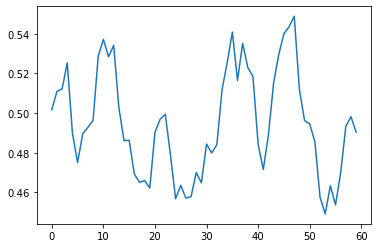

In [20]:
subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark = train_data.__getitem__(40)
out = plt.plot(batch_x[:, 0])

device = "cpu"

num_samples = 5
subj_id = torch.tensor(subj_id).unsqueeze(0).repeat_interleave(num_samples, 0).float().to(device)
batch_x = torch.tensor(batch_x).unsqueeze(0).repeat_interleave(num_samples, 0).float().to(device)
batch_y = torch.tensor(batch_y).unsqueeze(0).repeat_interleave(num_samples, 0).float().to(device)
batch_x_mark = torch.tensor(batch_x_mark).float().unsqueeze(0).repeat_interleave(num_samples, 0).to(device)
batch_y_mark = torch.tensor(batch_y_mark).float().unsqueeze(0).repeat_interleave(num_samples, 0).to(device)
# decoder input
dec_inp = torch.zeros([batch_y.shape[0], len_pred, batch_y.shape[-1]]).float().to(device)
dec_inp = torch.cat([batch_y[:, :len_label, :], dec_inp], dim=1).float().to(device)

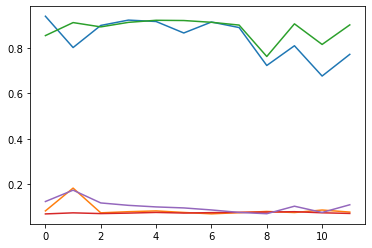

In [25]:
model.load_state_dict(torch.load('model_best_exp.pth', map_location=device))
model.to(device)
model.train()
pred, logvar = model(subj_id, batch_x, batch_x_mark, dec_inp, batch_y_mark)

out = plt.plot(pred[:, :, 0].permute(1, 0).detach().cpu().numpy())
plt.show()

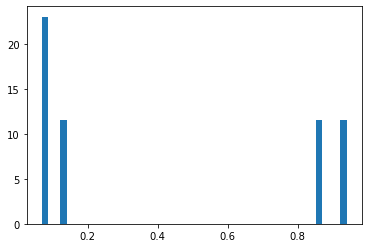

In [26]:
out = plt.hist(pred.detach().cpu().numpy()[:, 0, 0], bins=50, density=True)

In [27]:
plot_sample = []
pred = pred.detach().cpu().numpy()
logvar = logvar.detach().cpu().numpy()

for j in range(len_pred):
    s = []
    for i in range(num_samples):
       s += list(np.random.normal(pred[i, j, 0], np.sqrt(np.exp(logvar[i, 0, 0])), 100))
    plot_sample.append(s)

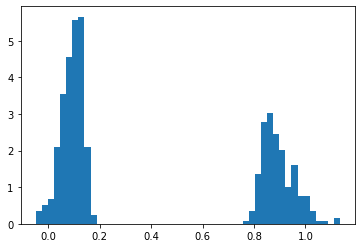

In [28]:
out = plt.hist(plot_sample[0], bins=50, density=True)

In [39]:
pd.DataFrame(np.matrix(plot_sample)).to_csv('./saved_output/exp/pred_sample.csv', index=False)
pd.DataFrame(batch_x[0, :, 0].numpy()).to_csv('./saved_output/exp/input.csv', index=False)
pd.DataFrame(batch_y[0, :, 0].numpy()).to_csv('./saved_output/exp/output.csv', index=False)
pd.DataFrame(pred[:, :, 0]).to_csv('./saved_output/exp/pred.csv', index=False)
pd.DataFrame(logvar[:, 0, 0]).to_csv('./saved_output/exp/pred_var.csv', index=False)